In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# read the words
words = open('names.txt', 'r').read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [7]:
# build the vocabulary
chars = sorted(list(set(''.join(words))))
s_to_i = {'.' : 0} | {s: i + 1 for i, s in enumerate(chars)}
i_to_s = {i: s for s, i in s_to_i.items()}
vocab_size = len(i_to_s)
print(i_to_s)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [53]:
# build the dataset

block_size = 3 # context length (how many chars to predict next)

def build_dataset(words):
	X, Y = [], []

	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			idx = s_to_i[ch]
			X.append(context)
			Y.append(idx)
			context = context[1:] + [idx]
	
	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

X_train,	Y_train	= build_dataset(words[:n1])		# 80%
X_val,		Y_val	= build_dataset(words[n1:n2])	# 10%
X_test,		Y_test	= build_dataset(words[n2:])		# 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [62]:
n_embd = 10 # embedding size
n_hidden = 200 # hidden layer size

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),				generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),	generator=g) * 0.2
b1 = torch.randn((n_hidden,),						generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),			generator=g) * 0.01
b2 = torch.randn((vocab_size,),						generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

11897


In [63]:
max_steps = 200000
lossi = []

In [64]:
batch_size = 32

for i in range(max_steps):
	
	# minibatch
	minibatch = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
	Xb, Yb = X_train[minibatch], Y_train[minibatch]

	# forward pass
	emb = C[Xb] # embed chars to vectors
	emb_cat = emb.view(emb.shape[0], -1) # concatenate embeddings
	h_preact = emb_cat @ W1 + b1 # hidden layer preactivation
	h = torch.tanh(h_preact) # hidden layer activation
	logits = h @ W2 + b2 # output layer
	loss = F.cross_entropy(logits, Yb) # loss function

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	if i < 100000:
		lr = 0.1
	elif i < 150000:
		lr = 0.01
	else:
		lr = 0.003
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/ {max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())

      0/  200000: 3.3091
  10000/  200000: 2.4062
  20000/  200000: 2.2719
  30000/  200000: 2.0326
  40000/  200000: 1.9983
  50000/  200000: 2.4017
  60000/  200000: 2.2712
  70000/  200000: 2.0150
  80000/  200000: 1.9887
  90000/  200000: 2.0578
 100000/  200000: 2.4542
 110000/  200000: 2.1407
 120000/  200000: 2.0326
 130000/  200000: 2.3694
 140000/  200000: 2.1493
 150000/  200000: 2.3643
 160000/  200000: 2.0678
 170000/  200000: 2.0669
 180000/  200000: 2.1853
 190000/  200000: 1.8981


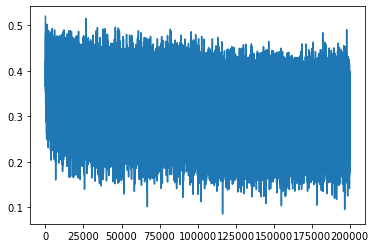

In [65]:
plt.plot(lossi)

In [66]:
@torch.no_grad() # disable autograd
def split_loss(split):
	x, y = {
		'train': (X_train, Y_train),
		'val': (X_val, Y_val),
		'test': (X_test, Y_test)
	}[split]
	emb = C[x] # (N, block_size, n_embd)
	emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
	h_preact = emb_cat @ W1 + b1 # (N, n_hidden)
	h = torch.tanh(h_preact) # (N, n_hidden)
	logits = h @ W2 + b2 # (N, vocab_size)
	loss = F.cross_entropy(logits, y)
	print(f'{split:5s} | loss: {loss.item():.6f}')

split_loss('train')
split_loss('val')

train | loss: 2.030177
val   | loss: 2.096633


In [73]:
for _ in range(20):
	out = []
	context = [0] * block_size # init with: '...'
	while True:
		# forward pass the neural net
		emb = C[torch.tensor(context)] # (1, block_size, n_embd)
		h = torch.tanh(emb.view(1, -1) @ W1 + b1)
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		# sample from the distribution
		ix = torch.multinomial(probs, num_samples=1).item()
		# shift the context window
		context = context[1:] + [ix]
		out.append(ix)
		# if we generated the end token, break
		if ix == 0:
			break
	
	print(''.join(i_to_s[i] for i in out[:-1])) # decode and print

brai
karlyn
xakhai
erson
amritha
zenia
vay
castny
zolyn
kahiba
astica
maubrena
adish
oluwe
eila
kenzaliyah
kida
jaylah
vanni
caria
